In [1]:
from functools import partial
from typing import Callable
import jax
import jax.numpy as jnp
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import emcee
from scipy.stats import multivariate_normal
import harmonic as hm
from harmonic import Evidence
from harmonic.evidence import compute_bayes_factor
from harmonic.utils import plot_getdist_compare, plot_getdist
import itertools
from dataclasses import dataclass
import logging

from harmonic.model_abstract import Model

In [2]:
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

## Define the unnormalised posterior

This is the distribution to be sampled, and for which we want to calculate the evidence.

In this example, we are dealing with zero-mean multivariate Gaussian distributions where the covariance is the identity matrix.
We will calculate the evidence for varying numbers of dimensions.

In [3]:
def ln_mvgaussian_posterior(x, inv_cov):
    """Compute log_e of posterior of n dimensional multivariate Gaussian.

    Args:

        x: Position at which to evaluate posterior.

    Returns:

        double: Value of posterior at x.

    """

    return -jnp.dot(x, jnp.dot(inv_cov, x)) / 2.0

batched_ln_mvgaussian_posterior = jax.vmap(ln_mvgaussian_posterior, in_axes=(0, None))

In the multivariate Gaussian case, we can easily write down the evidence.

In [4]:
def ln_analytic_evidence(ndim, cov):
    """Compute analytic evidence for nD Gaussian.

    Args:

        ndim: Dimension of Gaussian.

        cov: Covariance matrix.

    Returns:

        double: Analytic evidence.

    """

    ln_norm_lik = 0.5 * ndim * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(cov))
    return ln_norm_lik


In [5]:
def test_ln_mvgaussian():
    """Testing that the unnormalised log posterior combined with the log evidence gives the correct values.
    
    Test scenario is a 3D zero-mean Gaussian.  Compare with scipy.
    """

    mean = np.zeros(3)
    covariance = np.eye(3)

    x, y, z = np.mgrid[-3:3:.1, -3:3:.1, -3:3:.1]
    pos = np.empty((x.size, 3))
    pos[:, 0] = x.ravel()
    pos[:, 1] = y.ravel()
    pos[:, 2] = z.ravel()

    ln_posterior = batched_ln_mvgaussian_posterior(pos, covariance).reshape(x.shape)
    ln_evidence = ln_analytic_evidence(3, covariance)
    estimated_posterior = np.exp(ln_posterior - ln_evidence)

    rv = multivariate_normal(mean=mean, cov=covariance)
    expected_posterior = rv.pdf(pos).reshape(x.shape)

    assert np.allclose(estimated_posterior, expected_posterior), "Posterior does not match Gaussian PDF"

test_ln_mvgaussian()


### Define the different states we want to compare

Define a few covariance matrices.

In [6]:
COVARIANCES = [  # a bunch of nD Gaussians with unit covariance
    jnp.eye(5),
    jnp.eye(2),
    jnp.eye(3),
]

Plot an example.

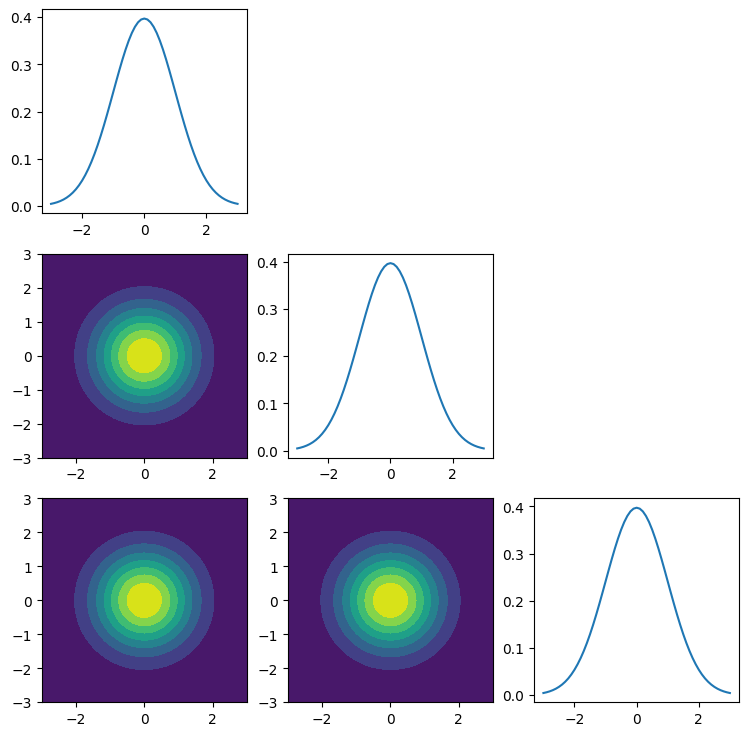

In [7]:
def plot_mv_gaussian(ndims: int) -> None:
    mean = np.zeros(ndims)
    cov = np.eye(ndims)

    # Create linspace for each dimension
    x_min = -3
    x_max = 3
    dx = 0.1
    axes_linspace = [np.arange(x_min, x_max + dx, dx) for _ in range(ndims)]

    # Create meshgrid from axes
    mesh = np.meshgrid(*axes_linspace, indexing="ij")  # shape: (ndims, D, D, ..., D)

    # Stack grid points into shape (num_points, ndims)
    grid_points = np.stack(mesh, axis=-1).reshape(-1, ndims)

    # Evaluate multivariate normal pdf at each point
    unnormed_ln_posterior = batched_ln_mvgaussian_posterior(grid_points, cov)
    ln_evidence = ln_analytic_evidence(ndims, cov)
    pdf_values = np.exp(unnormed_ln_posterior - ln_evidence).reshape(
        [len(axis) for axis in axes_linspace]
    )

    fig, axs = plt.subplots(ndims, ndims, figsize=(3 * ndims, 3 * ndims))
    for i in range(ndims):
        for j in range(ndims):
            ax = axs[i, j]
            if i == j:
                # Marginal along dimension i: integrate out all other dims
                axes_to_marginalise = tuple(k for k in range(ndims) if k != i)
                marginal = np.sum(pdf_values, axis=axes_to_marginalise)
                marginal *= dx ** len(axes_to_marginalise)

                ax.plot(axes_linspace[i], marginal)
            elif i > j:
                # Pairwise marginal over dims (i,j): integrate out others
                axes_to_marginalise = tuple(k for k in range(ndims) if k not in (i, j))
                pairwise = np.sum(pdf_values, axis=axes_to_marginalise)
                pairwise *= dx ** len(axes_to_marginalise)

                X, Y = np.meshgrid(
                    axes_linspace[j], axes_linspace[i]
                )  # note axes order for plotting

                ax.contourf(X, Y, pairwise, cmap="viridis")
            else:
                ax.axis("off")


plot_mv_gaussian(3)

## Presampling

For both the learnt harmonic estimator and trans-c by ensemble resampling, we need to do some initial sampling of the posterior.
These samples will be used to create the ``target density'' or ``pseudo-prior''.

In [8]:
@dataclass
class PosteriorSamples:
    """A dataclass to hold posterior samples and their log posterior values."""

    samples: NDArray[np.float_]
    ln_posterior: NDArray[np.float_]

    def __repr__(self) -> str:
        return f"PosteriorSamples(n_dim={self.n_dim}, n_samples={self.n_samples})"

    @property
    def n_dim(self) -> int:
        return self.samples.shape[-1]

    @property
    def n_samples(self) -> int:
        if self.samples.ndim == 2:
            return self.samples.shape[0]
        elif self.samples.ndim == 3:
            return self.samples.shape[0] * self.samples.shape[1]
        else:
            raise ValueError("Unsupported shape for samples array")

    def as_dataframe(self) -> pd.DataFrame:
        """Convert the posterior samples to a pandas DataFrame."""
        df = pd.DataFrame(
            self.samples.reshape(self.n_samples, self.n_dim),
            columns=[f"x{i}" for i in range(self.n_dim)],
        )
        df["log_posterior"] = self.ln_posterior.reshape(self.n_samples)
        return df


def perform_sampling(
    ln_posterior: Callable[[NDArray[np.float_]], float],
    ndim: int,
    nchains: int = 200,
    samples_per_chain: int = 5000,
    nburn: int = 2000,
) -> tuple[NDArray[np.float_], NDArray[np.float_]]:
    sampler = emcee.EnsembleSampler(nchains, ndim, ln_posterior)

    rng = np.random.default_rng(42)

    pos = rng.random((nchains, ndim))
    rstate = rng.bit_generator.state
    pos, _, _ = sampler.run_mcmc(pos, samples_per_chain, rstate0=rstate, progress=True)

    samples = np.ascontiguousarray(sampler.chain[:, nburn:, :])
    lnprob = np.ascontiguousarray(sampler.lnprobability[:, nburn:])
    return samples, lnprob


posteriors: list[PosteriorSamples] = []
for covariance in COVARIANCES:
    ln_posterior = partial(ln_mvgaussian_posterior, inv_cov=jnp.linalg.inv(covariance))
    samples, ln_posterior = perform_sampling(
        ln_posterior,
        ndim=covariance.shape[0],
    )
    posteriors.append(PosteriorSamples(samples=samples, ln_posterior=ln_posterior))

100%|██████████| 5000/5000 [00:19<00:00, 262.25it/s]


Check the samples

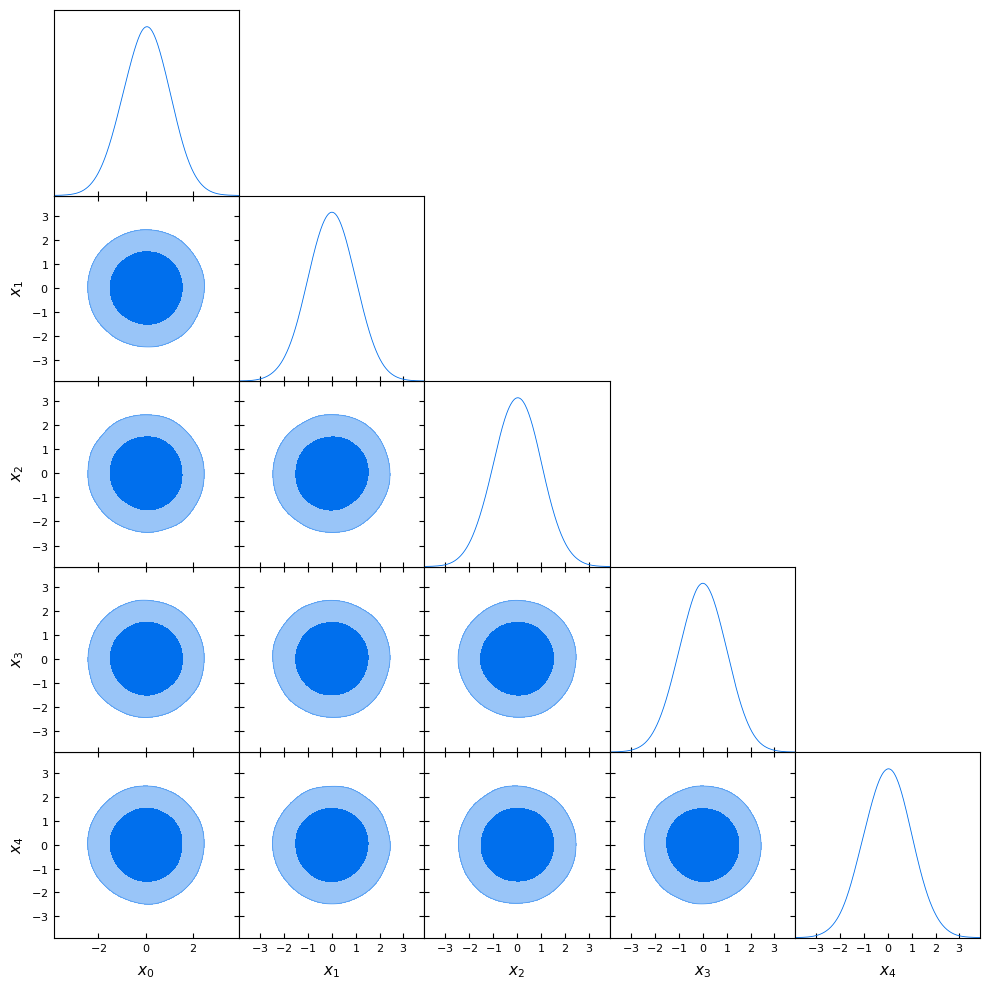

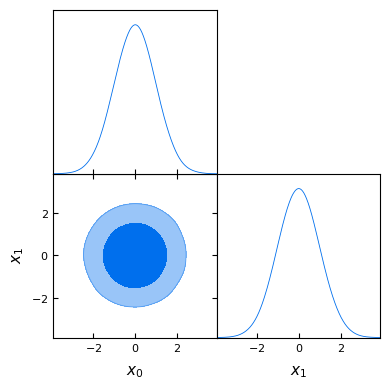

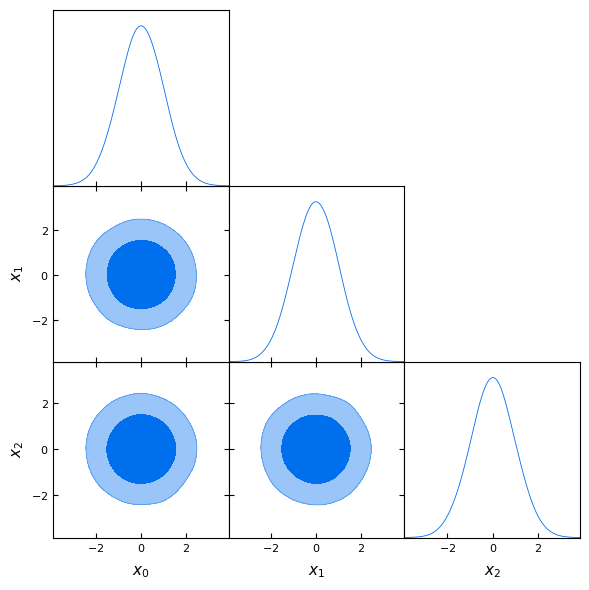

In [9]:
for posterior in posteriors:
    plot_getdist(posterior.samples.reshape(-1, posterior.n_dim))

## Train the pseudo-priors/target distributions

In [10]:
def train_harmonic_model(
    train_samples: NDArray[np.float_],
    train_lnprob: NDArray[np.float_],
    temperature: float = 0.8,
) -> Model:
    """
    Trains a model from harmonic
    """

    ndim = train_samples.shape[2]
    chains = hm.Chains(ndim)
    chains.add_chains_3d(train_samples, train_lnprob)

    # Using the default model for now
    if temperature > 1:
        temperature = 1.0
    if temperature < 0:
        temperature = 0.0
    model = hm.model.RealNVPModel(ndim, standardize=True, temperature=temperature)
    epochs_num = 20
    model.fit(chains.samples, epochs=epochs_num, verbose=True)

    return model


In [11]:
def split_data(
    samples: NDArray[np.float_],
    lnprob: NDArray[np.float_],
    training_proportion: float = 0.5,
) -> tuple[
    NDArray[np.float_], NDArray[np.float_], NDArray[np.float_], NDArray[np.float_]
]:

    nchains, nsamples, ndim = samples.shape
    ntraining = int(training_proportion * nsamples)
    training_samples = samples[:, :ntraining, :]
    training_lnprob = lnprob[:, :ntraining]
    inference_samples = samples[:, ntraining:, :]
    inference_lnprob = lnprob[:, ntraining:]
    return training_samples, training_lnprob, inference_samples, inference_lnprob

In [12]:

models: list[Model] = []
for posterior in posteriors:
    training_samples, training_lnprob, _, _ = split_data(
        posterior.samples, posterior.ln_posterior
    )
    models.append(train_harmonic_model(training_samples, training_lnprob, temperature=0.9))

Training NF: 100%|██████████| 20/20 [00:46<00:00,  2.31s/it]


## Compare the pseudo-prior to the sampled posterior

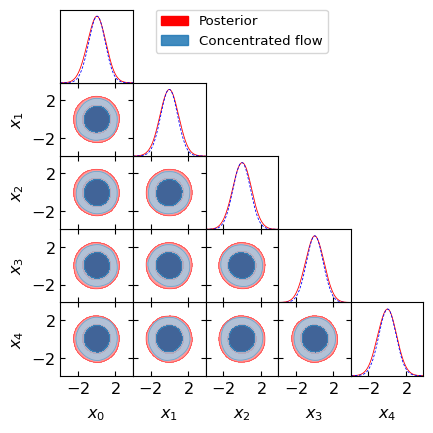

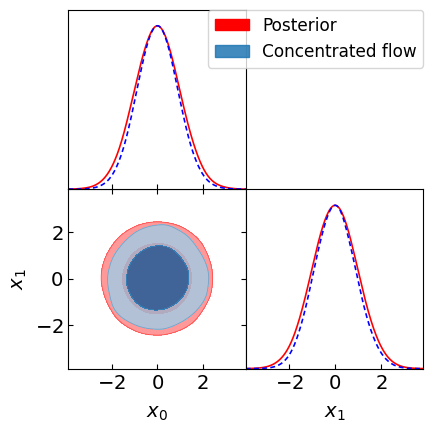

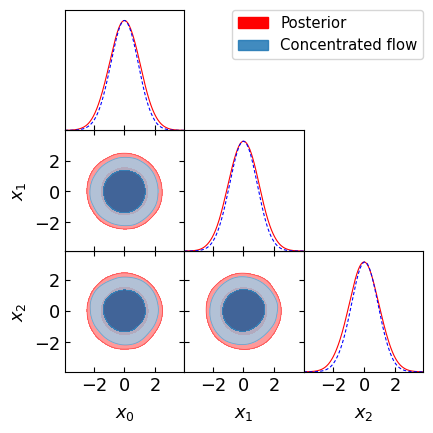

In [13]:
for model, posterior in zip(models, posteriors):
    plot_getdist_compare(
        posterior.samples.reshape(-1, posterior.n_dim),
        model.sample(posterior.n_samples),
    )

## Calculate the harmonic estimate of the evidence

In [14]:
def compute_harmonic_evidence(
    inference_samples: NDArray[np.float_],
    inference_lnprob: NDArray[np.float_],
    model: Model,
) -> hm.Evidence:
    ndim = inference_samples.shape[2]
    chains_infer = hm.Chains(ndim)
    chains_infer.add_chains_3d(inference_samples, inference_lnprob)

    ev = hm.Evidence(chains_infer.nchains, model)
    ev.add_chains(chains_infer)
    return ev

In [15]:
evidences: list[Evidence] = []
for posterior, model in zip(posteriors, models):
    _, _, inference_samples, inference_lnprob = split_data(
        posterior.samples, posterior.ln_posterior
    )
    evidences.append(
        compute_harmonic_evidence(inference_samples, inference_lnprob, model)
    )

for covariance, evidence in zip(COVARIANCES, evidences):
    e, e_std = evidence.compute_evidence()
    logger.info(f"Evidence (harmonic) = {e} +/- {e_std}")
    logger.info(
        f"Evidence (analytic) = {np.exp(ln_analytic_evidence(covariance.shape[0], covariance))}"
    )

2025-08-19 15:17:00,954 - __main__ - INFO - Evidence (harmonic) = 98.85630196060487 +/- 0.19979320135301246
2025-08-19 15:17:00,954 - __main__ - INFO - Evidence (analytic) = 98.95771780477251
2025-08-19 15:17:00,955 - __main__ - INFO - Evidence (harmonic) = 6.2814899851119534 +/- 0.006057338116853976
2025-08-19 15:17:00,955 - __main__ - INFO - Evidence (analytic) = 6.283185307179585
2025-08-19 15:17:00,956 - __main__ - INFO - Evidence (harmonic) = 15.762167982653517 +/- 0.0241980479638727
2025-08-19 15:17:00,956 - __main__ - INFO - Evidence (analytic) = 15.749609945722415


In [16]:
logger.info("Computing Bayes factor")
combos = itertools.combinations(evidences, 2)
for rml1, evidence2 in combos:
    bf, bf_std = compute_bayes_factor(rml1, evidence2)
    logger.info(f"Bayes factor: {bf} +/- {bf_std}")

2025-08-19 15:17:00,960 - __main__ - INFO - Computing Bayes factor
2025-08-19 15:17:00,961 - __main__ - INFO - Bayes factor: 15.737730413129585 +/- 0.03524172286751982
2025-08-19 15:17:00,961 - __main__ - INFO - Bayes factor: 6.271759855592131 +/- 0.015917739653845474
2025-08-19 15:17:00,962 - __main__ - INFO - Bayes factor: 0.39851783021478326 +/- 0.0007224880571967158


## TransC resampling

Evaluate the pseudo-prior at all the samples

In [17]:
@dataclass
class PseudoPriors:
    samples: NDArray[np.float_]
    ln_pseudo_prior: NDArray[np.float_]

    def __repr__(self) -> str:
        return f"PseudoPriors(n_dim={self.n_dim}, n_samples={self.n_samples})"

    @property
    def n_dim(self) -> int:
        return self.samples.shape[1]

    @property
    def n_samples(self) -> int:
        return self.samples.shape[0]


pseudo_priors: list[PseudoPriors] = []
for posterior, model in zip(posteriors, models):
    samples = posterior.samples.reshape(-1, posterior.n_dim)
    pp = model.predict(samples)
    pseudo_priors.append(
        PseudoPriors(samples=samples, ln_pseudo_prior=pp)
    )

In [18]:
from pyTransC.samplers import run_ensemble_resampler

resampled_chains = run_ensemble_resampler(
    n_walkers=32,
    n_steps=500_000,
    n_states=3,
    n_dims=[prior.n_dim for prior in pseudo_priors],
    log_posterior_ens=[post.ln_posterior.reshape(post.n_samples) for post in posteriors],
    log_pseudo_prior_ens=[prior.ln_pseudo_prior.reshape(prior.n_samples) for prior in pseudo_priors],
    progress=True,
)

2025-08-19 15:17:05,341 - pyTransC.samplers.ensemble_resampler - INFO - 
Running ensemble resampler
2025-08-19 15:17:05,342 - pyTransC.samplers.ensemble_resampler - INFO - 
Number of walkers               : 32
2025-08-19 15:17:05,342 - pyTransC.samplers.ensemble_resampler - INFO - Number of states being sampled  : 3
2025-08-19 15:17:05,342 - pyTransC.samplers.ensemble_resampler - INFO - Dimensions of each state        : [5, 2, 3]
100%|██████████| 32/32 [19:41<00:00, 36.92s/it]


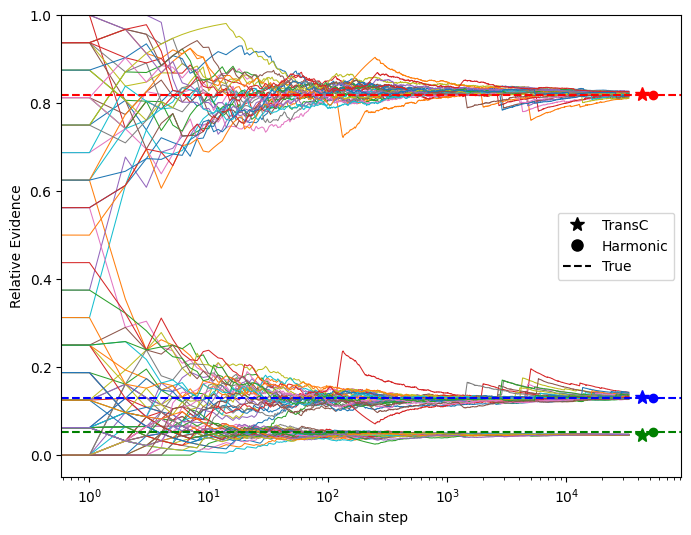

In [19]:
from pyTransC.analysis.visits import get_visits_to_states, get_relative_marginal_likelihoods
from matplotlib.lines import Line2D

discard = 0
thin = 15
visits, states_chain = get_visits_to_states(
    transc_sampler=resampled_chains,
    discard=discard,
    thin=thin,
    normalize=True,
)
visits = visits.swapaxes(0, 1)  # (n_steps, n_walkers, n_states)
states_chain = states_chain.swapaxes(0, 1)  # (n_steps, n_walkers)

fig, ax = plt.subplots(figsize=(8, 6))
ax.semilogx(visits.reshape(np.shape(visits)[0], -1), lw=0.75)
ax.set_xlabel("Chain step")
ax.set_ylabel("Relative Evidence")
ax.set_ylim(-0.05, 1.0)

rml_transc = get_relative_marginal_likelihoods(visits[-1], "median")
ax.plot(len(visits) * 1.3, rml_transc[0], "r*", markersize=10)
ax.plot(len(visits) * 1.3, rml_transc[1], "g*", markersize=10)
ax.plot(len(visits) * 1.3, rml_transc[2], "b*", markersize=10)

Ev = [evidence.compute_evidence()[0] for evidence in evidences]
rml_harmonic = [e / sum(Ev) for e in Ev]
Ev_std = [evidence.compute_evidence()[1] for evidence in evidences]
rml_std_harmonic = [e / sum(Ev) for e in Ev_std]
ax.errorbar(len(visits) * 1.6, rml_harmonic[0], yerr=rml_std_harmonic[0], fmt="ro")
ax.errorbar(len(visits) * 1.6, rml_harmonic[1], yerr=rml_std_harmonic[1], fmt="go")
ax.errorbar(len(visits) * 1.6, rml_harmonic[2], yerr=rml_std_harmonic[2], fmt="bo")


true_evidences = [
    np.exp(ln_analytic_evidence(cov.shape[0], cov)) for cov in COVARIANCES
]
rml_true = [e / sum(true_evidences) for e in true_evidences]
ax.axhline(rml_true[0], ls="--", c="r")
ax.axhline(rml_true[1], ls="--", c="g")
ax.axhline(rml_true[2], ls="--", c="b")


legend_elements = [
    Line2D(
        [0],
        [0],
        marker="*",
        color="k",
        linestyle="None",
        markersize=10,
        label="TransC",
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="k",
        linestyle="None",
        markersize=8,
        label="Harmonic",
    ),
    Line2D(
        [0], [0], color="k", linestyle="--", markersize=12, label="True"
    ),
]
ax.legend(handles=legend_elements, loc="best")

### Get the Bayes Factor from relative marginal likelihoods

In [20]:
logger.info("Computing Bayes factor (TransC)")
combos = itertools.combinations(rml_transc, 2)
for rml1, rml2 in combos:
    bf = rml1 / rml2
    logger.info(f"Bayes factor: {bf}")

2025-08-19 15:36:50,244 - __main__ - INFO - Computing Bayes factor (TransC)
2025-08-19 15:36:50,245 - __main__ - INFO - Bayes factor: 17.652461836164267
2025-08-19 15:36:50,245 - __main__ - INFO - Bayes factor: 6.190693781527812
2025-08-19 15:36:50,245 - __main__ - INFO - Bayes factor: 0.3506986073095512
